In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import tensorflow as tf

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber, LogCosh

2025-04-22 17:52:48.841121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745337168.885604  797341 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745337168.899521  797341 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745337168.970628  797341 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745337168.970695  797341 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745337168.970698  797341 computation_placer.cc:177] computation placer alr

In [2]:
def load_dataset(up_to= None):
    '''
    Charge les fichiers DVF jusqu'à une année donnée (incluse).

    Paramètres:
        up_to (str): Année maximale à charger, ex: "2020", "2023".

    Return:
        DataFrame Pandas combiné sans doublons.
    '''

    data_files = {
        "2019": "data/ValeursFoncieres-2019-S2.txt",
        "2020": "data/ValeursFoncieres-2020.txt",
        "2021": "data/ValeursFoncieres-2021.txt",
        "2022": "data/ValeursFoncieres-2022.txt",
        "2023": "data/ValeursFoncieres-2023.txt",
        "2024": "data/ValeursFoncieres-2024-S1.txt",
    }

    valid_years = list(data_files.keys())
    if (up_to is not None) and (up_to not in valid_years):
        print("Erreur: \"up_to\" doit être une année entre \"2019\" et \"2024\".")
        return -1

    data_list = []
    for year, path in data_files.items():
        print(f"Chargement {year}...")
        df = pd.read_csv(path, delimiter='|', dtype= str)
        data_list.append(df)
        if (up_to is not None) and (year == up_to):
            break

    data = pd.concat(data_list, ignore_index= True)
    # data.drop_duplicates(inplace=True) #? Fait crash le kernel, désactivé pour le moment
    print(f"\n{len(data):,} lignes chargées au total.")

    return data

def parse_dataset(dataset, min_price= 1_000, max_price= 2_000_000):
    '''
    Parsing des données, on ne garde que les lignes des ventes et de certains types de local.
    Seule les colonnes suivantes sont gardées : "Valeur fonciere", "Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales".
    Les lignes comportant des NaN sont supprimées.
    Ajout de colonnes pour "Année", "Mois", "Jour".
    Valeurs de target plafonnée.

    Paramètres:
        dataset (dataset): strucutre d'un fichier DVF.
        max_price (float): valeur maximum de target.

    Retour:
        dataFrames Pandas, X contenant les features et y contenant la target.
    '''

    if max_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price >= max_price:
        print("Erreur: \"min_price\" doit être < à \"max_price\"")
        return -1

    dataset = dataset[(dataset["Nature mutation"] == "Vente")]

    dataset = dataset.dropna(subset= ["Date mutation", "Valeur fonciere", "Code departement", "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain", "Code postal"])
    dataset["Valeur fonciere"] = dataset["Valeur fonciere"].str.replace(",", ".", regex= False).astype(float)
    dataset["Date mutation"] = pd.to_datetime(dataset["Date mutation"], format="%d/%m/%Y", errors="coerce")
    # dataset["Annee"] = dataset["Date mutation"].dt.year
    dataset["Mois"] = dataset["Date mutation"].dt.month
    # dataset["Jour"] = dataset["Date mutation"].dt.day
    dataset["Surface reelle bati"] = dataset["Surface reelle bati"].str.replace(",", ".", regex= False).astype(float)
    dataset["Nombre pieces principales"] = dataset["Nombre pieces principales"].astype(int)
    dataset["Surface terrain"] = dataset["Surface terrain"].str.replace(",", ".", regex= False).astype(float)
    dataset["Code postal"] = dataset["Code postal"].astype(str)
    dataset["Prix au m2"] = dataset["Valeur fonciere"] / dataset["Surface reelle bati"]

    freq_cp = dataset["Code postal"].value_counts()
    dataset["Frequence CP"] = dataset["Code postal"].map(freq_cp)
    dataset = dataset[(dataset["Type local"] == "Maison") | (dataset["Type local"] == "Appartement")]
    dataset = dataset[(dataset["Valeur fonciere"] >= min_price) &
                (dataset["Valeur fonciere"] <= max_price) &
                (dataset["Surface reelle bati"] >= 15) &
                (dataset["Surface reelle bati"] <= 300) &
                (dataset["Surface terrain"] <= 10_00) &
                (dataset["Nombre pieces principales"] >= 1) &
                (dataset["Nombre pieces principales"] <= 12)
                # (dataset["Prix au m2"] >= 300) &
                # (dataset["Prix au m2"] <= 10_000)
                ]
    features = ["Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Mois", "Frequence CP"]
    target = "Valeur fonciere"

    return dataset, features, target

def process_features(X):
    '''
    Normalise et classifie X.

    Paramètres:
        X (Dataframe): DataFrame contenant les features.

    Retour:
        La DataFrame d'entrée avec ses valeurs processées.
    '''

    categorical_features = ["Code departement", "Type local"]
    numeric_features = ["Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Mois", "Frequence CP"]
    preprocessor = ColumnTransformer(transformers= [(
        'num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown= 'ignore'), categorical_features)
        ])
    X_processed = preprocessor.fit_transform(X)

    return X_processed

In [258]:
def create_tf_dataset(X, y, batch_size= 2048):
    '''
    Create a tf.data.dataset for GPU usage.

    Parametres:
    Retour:
    '''
    X_array = X.toarray()
    dataset = tf.data.Dataset.from_tensor_slices((X_array, y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

    return dataset

def handle_dataset(dataset, features, target, sampled= True, sample_size= 1e5, log= True):
    X, y = dataset[features], dataset[target]

    if sampled is True:
        X_sampled = X.sample(n= int(sample_size))
        y_sampled = y.loc[X_sampled.index]
        X_processed = process_features(X_sampled)
        y = y_sampled
    else:
        X_processed = process_features(X)

    if log is True:
        y = np.log1p(y)

    X_temp, X_test, y_temp, y_test = train_test_split(X_processed, y, test_size= .2)
    X_train, X_vali, y_train, y_vali = train_test_split(X_temp, y_temp, test_size= .2)

    return X_train, X_vali, X_test, y_train, y_vali, y_test

def show_model_stats(X_test, y_test, model, model_history):
    y_pred = model.predict(X_test)
    y_pred_real = np.expm1(y_pred)
    y_test_real = np.expm1(y_test)
    lrate = model_history.history["learning_rate"]

    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = root_mean_squared_error(y_test_real, y_pred_real)
    r2 = r2_score(y_test_real, y_pred_real)
    print(model.evaluate(X_test))
    print(f"MAE : {mae:.2f} €")
    print(f"RMSE : {rmse:.2f} €")
    print(f"R² : {r2:.4f}")
    print(f"lrate : [{lrate[0]}, {lrate[-1]}]")

    plt.figure(figsize= (12, 8))
    plt.subplot(211)
    plt.scatter(y_test_real, y_pred_real, alpha= .3, s= 1)
    plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
    plt.xlabel("Valeur réelle (€)")
    plt.ylabel("Valeur prédite (€)")
    plt.title("Prédictions MLP vs Réel")
    plt.grid(True)
    plt.loglog()

    plt.subplot(223)
    plt.plot(model_history.history["loss"], label= "training")
    plt.plot(model_history.history["val_loss"], label= "validation")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()

    plt.subplot(224)
    plt.plot(model_history.history["learning_rate"])
    plt.xlabel("epochs")
    plt.ylabel("lrate")
    plt.yscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return

def build_mlp_model(input_shape= 0, n_layers= 3, layer_size= 512, lrate= 1e-3, loss_function= "mse", layer_type= "constant"):

    if loss_function == "mse":
        loss = "mse"
    elif loss_function == "log_cosh":
        loss = LogCosh()
    elif loss_function == "huber":
        loss = Huber(delta= .1)
    else:
        print(f"Error: Unknown loss function, {loss_function}.")
        return -1

    model = Sequential(name= "MLP")
    model.add(Input(shape = (input_shape,)))
    model.add(Dense(layer_size, activation= "relu"))

    if layer_type == "constant":
        for _ in range(n_layers - 1):
            model.add(Dense(layer_size, activation= "relu"))
            model.add(BatchNormalization())
            model.add(Dropout(.3))
    elif layer_type == "shrinking":
        for n in range(1, n_layers - 1):
            model.add(Dense(int(layer_size / (2 ** n)), activation= "relu"))
            model.add(BatchNormalization())
            model.add(Dropout(.3))
    else:
        print(f"Error: Unknown layer type, {layer_type}.")
        return -1

    model.add(Dense(1))

    model.summary()
    model.compile(optimizer= Adam(learning_rate= lrate), loss= loss, metrics= ["mae"])

    return model

def build_resmlp_model(input_shape= 0, n_layers= 1, layer_size= 512, lrate= 1e-3, loss_function= "mse"):

    if loss_function == "mse":
        loss = "mse"
    elif loss_function == "log_cosh":
        loss = LogCosh()
    elif loss_function == "huber":
        loss = Huber(delta= .1)
    else:
        print("Error: Unknown loss function.")
        return -1

    input_layer = Input(shape= (input_shape,))
    x = Dense(layer_size, activation= "relu")(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(.3)(x)
    for _ in range(n_layers - 1):
        x_res = Dense(layer_size, activation= "relu")(x)
        x_res = BatchNormalization()(x_res)
        x_res = Dropout(.3)(x_res)
        x = Add()([x, x_res])
    shortcut = Dense(1)(input_layer)
    main_output = Dense(1)(x)
    output_layer = Add()([main_output, shortcut])
    # output_layer = Dense(1)(x)

    model = Model(inputs= input_layer, outputs= output_layer, name= "resMLP")
    model.summary()
    model.compile(optimizer= Adam(learning_rate= lrate), loss= loss, metrics= ["mae"])

    return model

In [4]:
data = load_dataset(up_to= "2021")

Chargement 2019...
Chargement 2020...
Chargement 2021...

10,162,527 lignes chargées au total.


In [5]:
dataset, features, target = parse_dataset(data, min_price= 10_000, max_price= 1_000_000)

In [203]:
X_train, X_vali, X_test, y_train, y_vali, y_test = handle_dataset(
    dataset,
    features,
    target,
    sampled= True,
    sample_size= 5e5,
    log= True,
)

In [214]:
batch_size= 4096
epochs= 200
input_shape = X_train.shape[1]

dataset_test = create_tf_dataset(X_test, y_test, batch_size)
dataset_train = create_tf_dataset(X_train, y_train, batch_size)
dataset_vali = create_tf_dataset(X_vali, y_vali, batch_size)

In [271]:
# model = build_mlp_model(
#     input_shape= input_shape,
#     n_layers= 4,
#     layer_size= 512,
#     lrate= 1e-3,
#     loss_function= "huber",
#     layer_type= "shrinking"
# )

model = build_resmlp_model(
    input_shape= input_shape,
    n_layers= 5,
    layer_size= 512,
    lrate= 1e-3,
    loss_function= "huber"
)

Model: "resMLP"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50      │ (None, 104)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_263 (Dense)   │ (None, 512)       │     53,760 │ input_layer_50[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_263[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_187         │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_264 (Dense)   │ (None, 512)       │    262,656 │ dropout_187[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_264[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_188         │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_132 (Add)       │ (None, 512)       │          0 │ dropout_187[0][0… │
│                     │                   │            │ dropout_188[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_265 (Dense)   │ (None, 512)       │    262,656 │ add_132[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_265[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_189         │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_133 (Add)       │ (None, 512)       │          0 │ add_132[0][0],    │
│                     │                   │            │ dropout_189[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_266 (Dense)   │ (None, 512)       │    262,656 │ add_133[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_266[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_190         │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_134 (Add)       │ (None, 512)       │          0 │ add_133[0][0],    │
│                     │                   │            │ dropout_190[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_267 (Dense)   │ (None, 512)       │    262,656 │ add_134[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_267[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,115,242 (4.25 MB)

 Trainable params: 1,110,122 (4.23 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [272]:
early_stop = EarlyStopping(patience= 10, restore_best_weights= True)
lr_scheduler = ReduceLROnPlateau(monitor= 'val_loss', factor= .5, patience= 5, min_lr= 1e-6)

history = model.fit(
    dataset_train,
    validation_data= dataset_vali,
    epochs= epochs,
    callbacks= [early_stop, lr_scheduler],
    verbose= 1
)

Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.8448 - mae: 8.4978 - val_loss: 0.6803 - val_mae: 6.8532 - learning_rate: 0.0010
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.1053 - mae: 1.1019 - val_loss: 0.2709 - val_mae: 2.7595 - learning_rate: 0.0010
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0799 - mae: 0.8471 - val_loss: 0.1706 - val_mae: 1.7556 - learning_rate: 0.0010
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0652 - mae: 0.7002 - val_loss: 0.1304 - val_mae: 1.3538 - learning_rate: 0.0010
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0572 - mae: 0.6202 - val_loss: 0.1005 - val_mae: 1.0545 - learning_rate: 0.0010
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0527 - mae: 0.5748 - val_loss: 0.0979 - val_mae: 1.0283 - learning_rate: 0.0010
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0487 - mae: 0.5347 - val_loss: 0.0772 - val_mae: 0.8216 - learning_rate: 0.0010
Epoch 8/200

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0343 - mae: 0.3897
[0.03436189144849777, 0.3902435600757599]
MAE : 77628.01 €
RMSE : 118230.19 €
R² : 0.4853
lrate : [0.0010000000474974513, 9.999999974752427e-07]


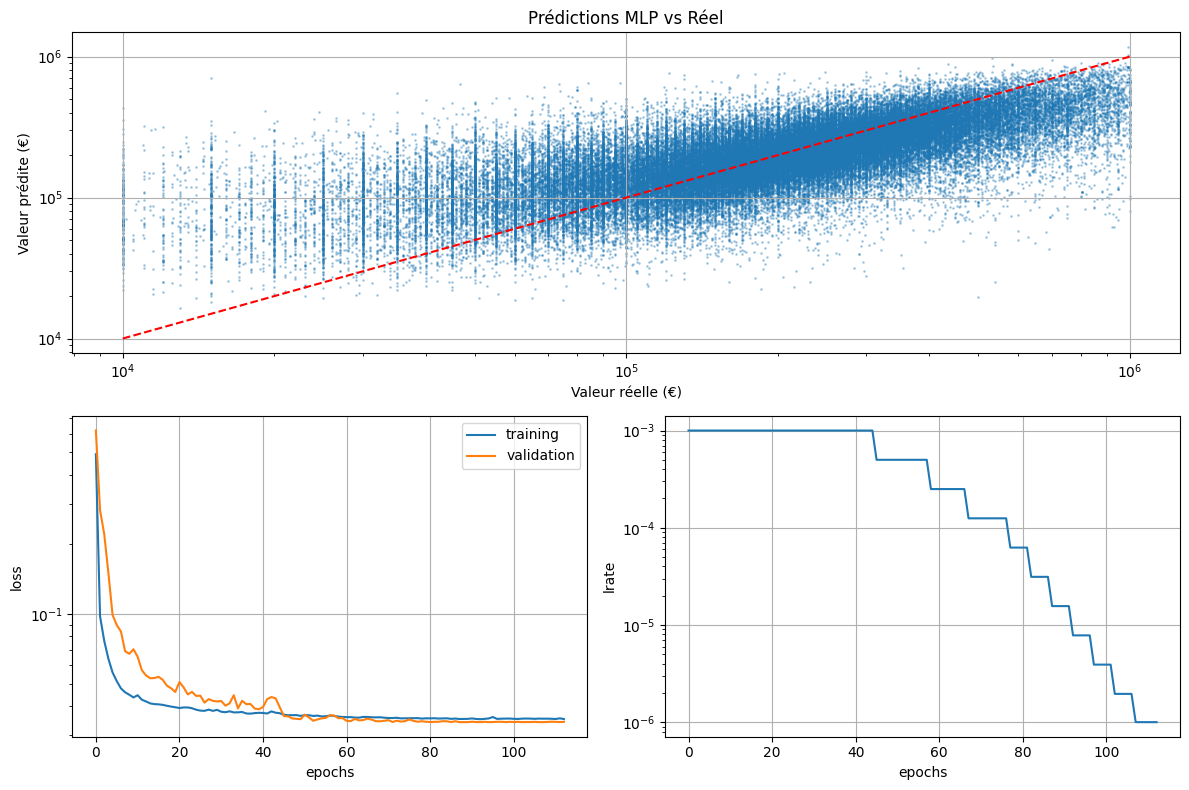

In [264]:
show_model_stats(dataset_test, y_test, model, history)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0346 - mae: 0.3923
[0.034588418900966644, 0.3926185071468353]
MAE : 78376.94 €
RMSE : 121063.15 €
R² : 0.4603
lrate : [0.0010000000474974513, 1.5625000742147677e-05]


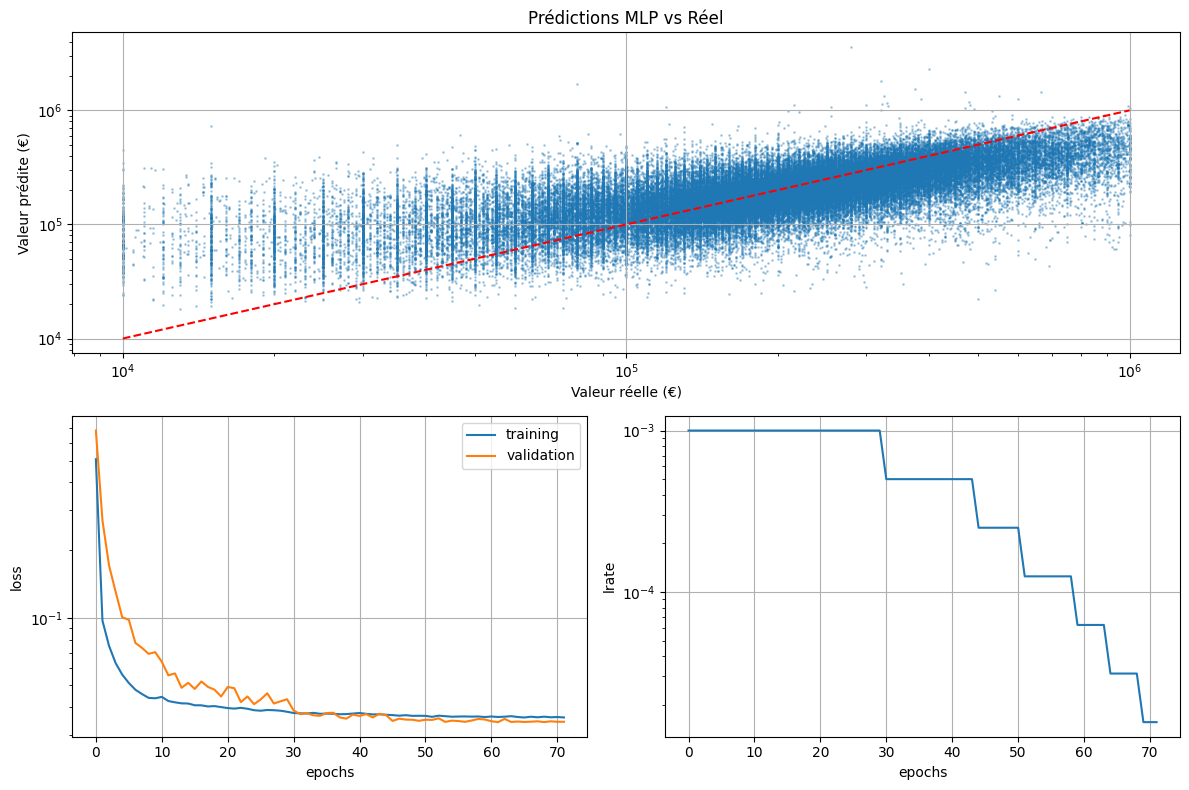

In [273]:
show_model_stats(dataset_test, y_test, model, history)